# **Atividade Proposta**

Avalie com validação cruzada o desempenho da ELM em um dataset não-artificial.

# **Importações de Bibliotecas e Funções Básicas**

In [154]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit

In [155]:
def geradataset(tamanho=20, centros=[[0,0],[1,0],[1,1],[0,1]]):
    X, y = make_blobs(n_samples=tamanho, centers=centros, cluster_std=0.2)
    y = np.array(y%2, dtype=int)
    return X, y

def plotadataset(X, y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

def plotahiperplano(vetor, bias=0, xmin=0, xmax=1):
    xs = np.linspace(xmin, xmax, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - bias / vetor[1]
    plt.plot(xs,ys)

# **Funções de Custo**

In [156]:
class CustoPerceptron():
    @staticmethod
    def erro(y, ypred):
        return y - ypred
    @staticmethod
    def custo(y, ypred):
        return np.sum(CustoPerceptron.erro(y, ypred)**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, CustoPerceptron.erro(y, ypred))

class Adaline():
    def __init__(self):
        self.preactivated = True
    @staticmethod
    def erro(y, ypred):
        return y - ypred
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - Adaline.erro(y, ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, Adaline.erro(y, ypred))

In [157]:
class DescidaGradiente():
    def __init__(self, custo=Adaline(), maxiter=1000, alpha=0.005):
        self.custo = custo
        self.maxiter = maxiter
        self.alpha = alpha
    
    def getW(self, X, y, activation=lambda a: a):
        w = np.random.uniform(-1, -1, size=(X.shape[1], y.shape[1]))
        for _ in range(self.maxiter):
            ypred = activation(np.matmul(X, w))
            custo = self.custo.custo(y, ypred)
            if custo == 0:
                break
            w = w + self.alpha * self.custo.gradiente(y, ypred, X)
        return w

class PseudoInversa():
    def __init__(self):
        pass
    def getW(self, X, y):
        pinv = np.linalg.pinv(X)
        w = np.matmul(pinv, y)
        return w

# **Implementação do ELM**

In [158]:
def tanh(a):
    return expit(a) * 2 - 1

class ExtremeLearningMachine(BaseEstimator, ClassifierMixin):
    def __init__(self, algoritmo=PseudoInversa()):
        self.wih = None
        self.w = None
        self.threshold = 0
        self.activation = tanh
        self.algoritmo = algoritmo
    
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb
    
    def fit(self, X, y):
        self.wih = np.random.uniform(-1, 1, size=(X.shape[1],X.shape[0]//3))
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        X = ExtremeLearningMachine.includebias(Xho)
        self.labels = list(set(y))
        y = label_binarize(y, classes=self.labels)*2-1
        if len(self.labels) == 2 :
            y = y[:,0:1]
        # treinamento
        if hasattr(self.algoritmo, 'custo') and not (hasattr(self.algoritmo.custo, 'preactivated') and self.algoritmo.custo.preactivated):
            self.w = self.algoritmo.getW(X, y, self.activation)
        else:
            self.w = self.algoritmo.getW(X, y)

    def predict(self, X):
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        Xb = ExtremeLearningMachine.includebias(Xho)
        a = np.matmul(Xb, self.w)
        if self.w.shape[1] > 1:
            idx = np.argmax(a, axis=1) 
        else:
            idx = np.array(self.activation(a) > self.threshold, dtype=int)[:,0]
        ypred = np.array([self.labels[i] for i in idx])
        return ypred

# **Testes e Demais atividades**

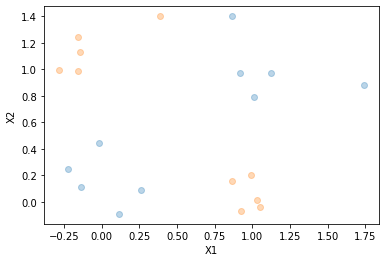

(array([[ 1.0102052 ,  0.79367909],
        [ 0.92156025, -0.06977538],
        [ 0.98814674,  0.19928452],
        [ 0.11227973, -0.09093049],
        [-0.13956389,  0.10961079],
        [ 1.05267762, -0.03916733],
        [ 0.86537508,  0.15415007],
        [ 1.02787483,  0.01291729],
        [ 1.74011019,  0.88365403],
        [-0.15960653,  0.98776015],
        [ 0.91814765,  0.97243936],
        [-0.1566748 ,  1.24369908],
        [-0.02217587,  0.44601778],
        [-0.14468268,  1.1281862 ],
        [-0.22179476,  0.2493235 ],
        [ 0.26026644,  0.09244527],
        [-0.28198737,  0.99644492],
        [ 0.86556268,  1.40023579],
        [ 0.38553222,  1.40126515],
        [ 1.12682384,  0.97412912]]),
 array([0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]))

In [159]:
X, y = geradataset()
plotadataset(X, y)
plt.show()
X,y

In [160]:
elm = ExtremeLearningMachine()
elm.fit(X, y)

In [161]:
ypred = elm.predict(X)
print(sum(y == ypred)/len(y))

1.0


In [162]:
# Teste com amostras fora do treinamento
Xte, yte = geradataset(10000)
ypred = elm.predict(Xte)
print(sum(yte == ypred)/len(yte))

0.9531


# **Validação Cruzada**

Avalie com validação cruzada o desempenho da ELM em um dataset não-artificial.

Data set não artificial encontrado no link:
https://www.kaggle.com/uciml/pima-indians-diabetes-database

coloquei ele no meu github : https://raw.githubusercontent.com/lopeslopesedu/202101_NeuralNetworks/main/diabetes.csv

Number of times pregnant.
Plasma glucose concentration a 2 hours in an oral glucose tolerance test.
Diastolic blood pressure (mm Hg).
Triceps skinfold thickness (mm).
2-Hour serum insulin (mu U/ml).
Body mass index (weight in kg/(height in m)^2).
Diabetes pedigree function.
Age (years).
Class variable (0 or 1).

In [163]:
data = pd.read_csv("https://raw.githubusercontent.com/lopeslopesedu/202101_NeuralNetworks/main/diabetes.csv",sep =",")

In [164]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [165]:
npdata = data.to_numpy()

In [166]:
#.tolist()
ydata = npdata[:,-1:]
Xdata = npdata[:,1:3]

In [167]:
target = np.zeros(ydata.size)
for i in range(len(ydata)):
  target[i] = ydata[i]
target.shape

(768,)

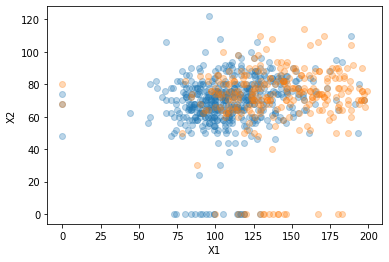

In [168]:
plotadataset(Xdata, target)
plt.show()

In [169]:
elm = ExtremeLearningMachine()
elm.fit(Xdata, target)

In [170]:
ypred = elm.predict(Xdata)
print(sum(target == ypred)/len(target))

0.78515625


In [171]:
from sklearn.model_selection import cross_val_score # Cross Validation Function.
from sklearn.model_selection import KFold # KFold Class.

In [172]:
model  = ExtremeLearningMachine()
kfold  = KFold(n_splits=5, shuffle=True) # shuffle=True, Shuffle (embaralhar) the data.
result = cross_val_score(model, Xdata, target, cv = kfold)

print("K-Fold (R^2) Scores: {0}".format(result))
print("Mean R^2 for Cross-Validation K-Fold: {0}".format(result.mean()))

K-Fold (R^2) Scores: [0.73376623 0.7012987  0.68831169 0.73202614 0.68627451]
Mean R^2 for Cross-Validation K-Fold: 0.7083354553942789


In [173]:
target = target.astype(int)

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


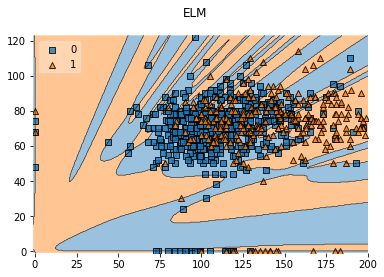

In [176]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
value = 1.5
width = 0.75
plot_decision_regions(Xdata, target, clf=elm,
                      filler_feature_values={2: value},
                      filler_feature_ranges={2: width},
                      legend=2, ax=ax)

fig.suptitle('ELM')
plt.show()